In [1]:
#code for training of model
#import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

import _pickle as cPickle

In [2]:
#read training and testing data
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
train.head()


,Unnamed: 0,text,label
0,0,The Rock is destined to be the 21st Century 's...,3
1,1,The gorgeously elaborate continuation of `` Th...,4
2,2,Singer\/composer Bryan Adams contributes a sle...,3
3,3,You 'd think by now America would have had eno...,2
4,4,Yet the act is still charming here .,3


In [3]:
#drop unwanted columns 
train=train.drop('Unnamed: 0',axis=1)
test=test.drop('Unnamed: 0',axis=1)
train.head()

,text,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer\/composer Bryan Adams contributes a sle...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [4]:
train.describe()

,label
count,8544.000000
mean,2.058052
std,1.281570
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8544 non-null   object
 1   label   8544 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


the above results show that our data has 2 columns and none of them are empty 

Text(0, 0.5, 'Count')

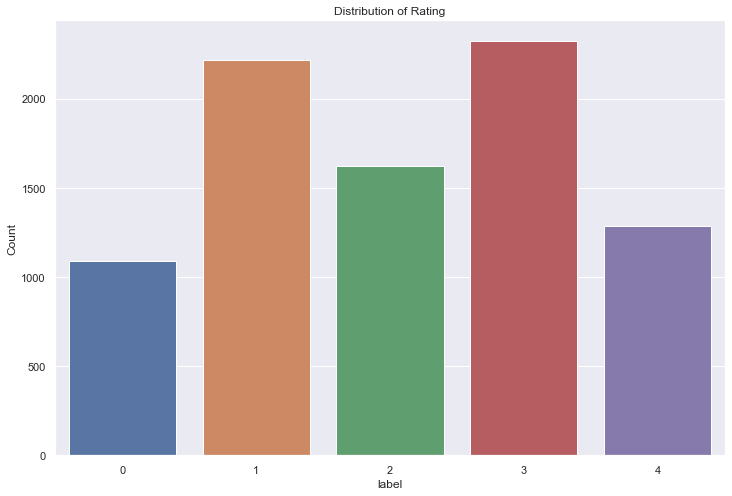

In [6]:
#count plot for different classes present in data
plt.figure(figsize=(12,8))
sns.countplot(train['label'])
plt.title('Distribution of Rating')
plt.xlabel('label')
plt.ylabel('Count')

In [7]:
#seperating the independent and dependent data
X_train=train['text']
Y_train=train['label']
X_test=train['text']
Y_test=train['label']


Text Preprocessing
The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [8]:
#clean the text
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
        #stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [10]:
# Preprocess text data in training set 
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
    
 
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))


### CountVectorizer with Mulinomial Naive Bayes
Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.


In [13]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, Y_train)

Number of features : 15137 

Show some feature names : 
 ['aaa', 'banter', 'centuries', 'crooning', 'dulled', 'findings', 'hands', 'intolerant', 'madcap', 'notches', 'pose', 'restrictive', 'simple', 'sunk', 'uncommonly', 'wounding']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(Y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(Y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(Y_test, predictions))

In [17]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.7914

Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.58      0.72      1092
           1       0.70      0.93      0.80      2218
           2       0.93      0.65      0.77      1624
           3       0.75      0.93      0.83      2322
           4       0.94      0.66      0.78      1288

    accuracy                           0.79      8544
   macro avg       0.85      0.75      0.78      8544
weighted avg       0.82      0.79      0.79      8544


Confusion Matrix : 
 [[ 633  359   23   74    3]
 [  17 2065   26  102    8]
 [  14  302 1059  237   12]
 [   3  119   16 2149   35]
 [   1   96   15  320  856]]


### TfidfVectorizer with Logistic Regression
Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [19]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_tfidf, Y_train)

Number of features : 3491 

Show some feature names : 
 ['10', 'entire', 'mushy', 'suspenseful']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['but' 'best' 'while' 'with' 'may' 'love' 'heart' 'worth' 'right' 'good']

Top 10 features with largest coefficients : 
['worst' 'bad' 'dull' 'stupid' 'mess' 'awful' 'horrible' 'ugly' 'terrible'
 'incoherent']


In [21]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.6671

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.42      0.56      1092
           1       0.61      0.81      0.70      2218
           2       0.72      0.49      0.58      1624
           3       0.63      0.82      0.71      2322
           4       0.81      0.57      0.67      1288

    accuracy                           0.67      8544
   macro avg       0.72      0.62      0.64      8544
weighted avg       0.69      0.67      0.66      8544


Confusion Matrix : 
 [[ 461  407   73  134   17]
 [  50 1796  114  228   30]
 [  30  400  791  363   40]
 [  14  219   84 1915   90]
 [  12  100   40  399  737]]


### Pipeline and GridSearch
In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [23]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression(max_iter=5000))]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, Y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 1, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9170

Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.73      0.84      1092
           1       0.87      0.99      0.93      2218
           2       0.99      0.91      0.94      1624
           3       0.87      0.99      0.93      2322
           4       0.99      0.83      0.90      1288

    accuracy                           0.92      8544
   macro avg       0.94      0.89      0.91      8544
weighted avg       0.93      0.92      0.92      8544


Confusion Matrix : 
 [[ 795  198   10   87    2]
 [   3 2197    1   15    2]
 [   0   64 1472   85    3]
 [   1   19    0 2298    4]
 [   1   54   11  149 1073]]


In [24]:
pickleFile = open('model', 'wb')
cPickle.dump(grid,pickleFile,-1)